In [3]:
from maad.util import (
    date_parser, 
    plot_correlation_map,
    plot_features_map, 
    plot_features, 
    false_Color_Spectro
)
from maad import sound, features
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
import yaml
import sys
import os

In [4]:
SPECTRAL_FEATURES=['MEANf','VARf','SKEWf','KURTf','NBPEAKS','LEQf',
'ENRf','BGNf','SNRf','Hf', 'EAS','ECU','ECV','EPS','EPS_KURT','EPS_SKEW','ACI',
'NDSI','rBA','AnthroEnergy','BioEnergy','BI','ROU','ADI','AEI','LFC','MFC','HFC',
'ACTspFract','ACTspCount','ACTspMean', 'EVNspFract','EVNspMean','EVNspCount',
'TFSD','H_Havrda','H_Renyi','H_pairedShannon', 'H_gamma', 'H_GiniSimpson','RAOQ',
'AGI','ROItotal','ROIcover']

TEMPORAL_FEATURES=['ZCR','MEANt', 'VARt', 'SKEWt', 'KURTt',
               'LEQt','BGNt', 'SNRt','MED', 'Ht','ACTtFraction', 'ACTtCount',
               'ACTtMean','EVNtFraction', 'EVNtMean', 'EVNtCount']

Below is the only cell one needs to change to run the processing for the new dataset.

In [5]:
conf_file = "FS1.yaml"

Make sure the output below is correct (data location is correct and the settings are appropriate).

In [6]:
proj_path = Path(os.getcwd()).parent
with open(proj_path / "conf" / conf_file, "r") as f:
    conf = yaml.safe_load(f)
yaml.dump(conf, sys.stdout)

data:
  path: data/Brazil/package-1-update/FS1/FS1
mic:
  gain: 18
  sensitivity: -4
spectral_alpha_indices:
  flim_hi:
  - 8000
  - 20000
  flim_low:
  - 0
  - 1500
  flim_mid:
  - 1500
  - 8000
  mask_param1: 6
  mask_param2: 0.5
spectrogram:
  noverlap: 512
  nperseg: 1024
  window: hann
temporal_alpha_indices:
  dB_threshold: 3
  rejectDuration: 0.01


In [7]:
data_path = proj_path / conf["data"]["path"]
data_path

PosixPath('/home/andrei/WUR/Projects/Ecoacoustics/ecoacoustics/data/Brazil/package-1-update/FS1/FS1')

In [8]:
df = date_parser(data_path, dateformat='SM4', extension=".wav", verbose=True)
df

FS1XXXXX_20230618_172702.wav
FS1XXXXX_20230528_065402.wav
FS1XXXXX_20230422_164200.wav
FS1XXXXX_20230408_165200.wav
FS1XXXXX_20230502_064402.wav
FS1XXXXX_20230422_054002.wav
FS1XXXXX_20230601_182602.wav
FS1XXXXX_20230425_184002.wav
FS1XXXXX_20230624_070202.wav
FS1XXXXX_20230413_174802.wav
FS1XXXXX_20230429_163700.wav
FS1XXXXX_20230531_055502.wav
FS1XXXXX_20230421_064002.wav
FS1XXXXX_20230621_182702.wav
FS1XXXXX_20230517_162900.wav
FS1XXXXX_20230427_163800.wav
FS1XXXXX_20230612_162600.wav
FS1XXXXX_20230530_182602.wav
FS1XXXXX_20230514_064802.wav
FS1XXXXX_20230514_173002.wav
FS1XXXXX_20230602_172602.wav
FS1XXXXX_20230526_182602.wav
FS1XXXXX_20230512_163000.wav
FS1XXXXX_20230426_044200.wav
FS1XXXXX_20230502_183502.wav
FS1XXXXX_20230525_065202.wav
FS1XXXXX_20230518_045000.wav
FS1XXXXX_20230614_172602.wav
FS1XXXXX_20230505_064502.wav
FS1XXXXX_20230522_172702.wav
FS1XXXXX_20230423_044100.wav
FS1XXXXX_20230411_175002.wav
FS1XXXXX_20230508_183202.wav
FS1XXXXX_20230507_173302.wav
FS1XXXXX_20230

file
Date                                                                  
2023-04-01 16:58:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-04-01 17:58:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-04-02 05:05:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-04-02 06:05:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-04-02 16:57:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
...                                                                ...
2023-06-23 17:28:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-06-23 18:28:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-06-24 05:02:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-06-24 06:02:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...
2023-06-24 07:02:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...

[477 rows x 1 columns]

In [9]:
df_indices = pd.DataFrame()
df_indices_per_bin = pd.DataFrame()

for index, row in df.iterrows():
    # get the full filename of the corresponding row
    fullfilename = row["file"]
    # Save file basename
    path, filename = os.path.split(fullfilename)
    print("\n**************************************************************")
    print(filename)

    #### Load the original sound (16bits) and get the sampling frequency fs
    try:
        wave, fs = sound.load(
            filename=fullfilename, channel="left", detrend=True, verbose=False
        )

    except:
        # Delete the row if the file does not exist or raise a value error (i.e. no EOF)
        df.drop(index, inplace=True)
        continue

    """ =======================================================================
                     Computation in the time domain
    ========================================================================"""

    # Parameters of the audio recorder. This is not a mandatory but it allows
    # to compute the sound pressure level of the audio file (dB SPL) as a
    # sonometer would do.
    # S = -35  # Sensbility microphone-35dBV (SM4) / -18dBV (Audiomoth)
    S = conf["mic"]["sensitivity"]
    # G = 26 + 16  # Amplification gain (26dB (SM4 preamplifier))
    G = conf["mic"]["gain"]

    # compute all the audio indices and store them into a DataFrame
    # dB_threshold and rejectDuration are used to select audio events.
    df_audio_ind = features.all_temporal_alpha_indices(
        wave,
        fs,
        gain=G,
        sensibility=S,
        dB_threshold=conf["temporal_alpha_indices"]["dB_threshold"],
        rejectDuration=conf["temporal_alpha_indices"]["rejectDuration"],
        verbose=False,
        display=False,
    )

    """ =======================================================================
                     Computation in the frequency domain
    ========================================================================"""

    # Compute the Power Spectrogram Density (PSD) : Sxx_power
    Sxx_power, tn, fn, ext = sound.spectrogram(
        wave,
        fs,
        window=conf["spectrogram"]["window"],
        nperseg=conf["spectrogram"]["nperseg"],
        noverlap=conf["spectrogram"]["noverlap"],
        verbose=False,
        display=False,
        savefig=None,
    )

    # compute all the spectral indices and store them into a DataFrame
    # flim_low, flim_mid, flim_hi corresponds to the frequency limits in Hz
    # that are required to compute somes indices (i.e. NDSI)
    # if R_compatible is set to 'soundecology', then the output are similar to
    # soundecology R package.
    # mask_param1 and mask_param2 are two parameters to find the regions of
    # interest (ROIs). These parameters need to be adapted to the dataset in
    # order to select ROIs
    df_spec_ind, df_spec_ind_per_bin = features.all_spectral_alpha_indices(
        Sxx_power,
        tn,
        fn,
        flim_low=conf["spectral_alpha_indices"]["flim_low"],
        flim_mid=conf["spectral_alpha_indices"]["flim_mid"],
        flim_hi=conf["spectral_alpha_indices"]["flim_hi"],
        gain=G,
        sensitivity=S,
        verbose=False,
        R_compatible="soundecology",
        mask_param1=conf["spectral_alpha_indices"]["mask_param1"],
        mask_param2=conf["spectral_alpha_indices"]["mask_param2"],
        display=False,
    )

    """ =======================================================================
                     Create a dataframe
    ========================================================================"""
    # First, we create a dataframe from row that contains the date and the
    # full filename. This is done by creating a DataFrame from row (ie. TimeSeries)
    # then transposing the DataFrame.
    df_row = pd.DataFrame(row)
    df_row = df_row.T
    df_row.index.name = "Date"
    df_row = df_row.reset_index()

    # add scalar indices into the df_indices dataframe
    df_indices = pd.concat(
        [df_indices, pd.concat([df_row, df_audio_ind, df_spec_ind], axis=1)]
    )
    # add vector indices into the df_indices_per_bin dataframe
    df_indices_per_bin = pd.concat(
        [df_indices_per_bin, pd.concat([df_row, df_spec_ind_per_bin], axis=1)]
    )


**************************************************************
FS1XXXXX_20230401_165800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230401_175802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230402_050500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230402_060502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230402_165700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230402_175702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230403_050500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230403_060502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230403_165700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230403_175702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230404_050500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230404_060502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230404_161400.wav

**************************************************************
FS1XXXXX_20230404_165600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230404_175602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230405_050600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230405_060602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230405_165500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230405_175502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230406_050600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230406_060602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230406_165400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230406_175402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230407_050600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230407_060602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230407_165300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230407_175302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230408_050600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230408_060602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230408_165200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230408_175202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230409_050700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230409_060702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230409_165200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230409_175202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230410_050700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230410_060702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230411_165000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230411_175002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230411_185002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230412_043800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230412_053802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230412_063802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230412_164900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230412_174902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230412_184902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230413_043800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230413_053802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230413_063802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230413_164800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230413_174802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230413_184802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230414_043800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230414_053802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230414_063802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230414_164800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230414_174802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230414_184802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230415_043800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230415_053802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230415_063802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230415_164700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230415_174702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230415_184702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230416_043900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230416_053902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230416_063902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230416_164600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230416_174602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230416_184602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230417_043900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230417_053902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230417_063902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230417_164500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230417_174502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230417_184502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230418_043900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230418_053902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230418_063902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230418_164500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230418_174502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230418_184502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230419_044000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230419_054002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230419_064002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230419_164400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230419_174402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230419_184402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230420_044000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230420_054002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230420_064002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230420_164300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230420_174302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230420_184302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230421_044000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230421_054002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230421_064002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230421_164200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230421_174202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230421_184202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230422_044000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230422_054002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230422_064002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230422_164200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230422_174202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230422_184202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230423_044100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230423_054102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230423_064102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230423_164100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230423_174102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230423_184102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230424_044100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230424_054102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230424_064102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230424_164000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230424_174002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230424_184002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230425_044100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230425_054102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230425_064102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230425_164000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230425_174002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230425_184002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230426_044200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230426_054202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230426_064202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230426_163900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230426_173902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230426_183902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230427_044200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230427_054202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230427_064202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230427_163800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230427_173802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230427_183802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230428_044200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230428_054202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230428_064202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230428_163800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230428_173802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230428_183802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230429_044300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230429_054302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230429_064302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230429_163700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230429_173702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230429_183702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230430_044300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230430_054302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230430_064302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230430_163700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230430_173702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230430_183702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230501_064302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230501_163600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230501_173602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230501_183602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230502_044400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230502_054402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230502_064402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230502_163500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230502_173502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230502_183502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230503_044400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230503_054402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230503_064402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230503_163500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230503_173502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230503_183502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230504_044400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230504_054402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230504_064402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230504_163400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230504_173402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230504_183402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230505_044500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230505_064502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230505_163400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230505_173402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230505_183402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230506_044500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230506_054502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230506_064502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230506_163300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230506_173302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230506_183302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230507_044500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230507_054502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230507_064502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230507_163300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230507_173302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230507_183302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230508_044600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230508_054602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230508_064602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230508_163200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230508_173202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230508_183202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230509_044600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230509_054602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230509_064602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230509_163200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230509_173202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230509_183202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230510_044700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230510_054702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230510_065425.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230510_163100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230510_173102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230510_183102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230511_044700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230511_054702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230511_064702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230511_163100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230511_173102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230511_183102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230512_044700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230512_054702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230512_064702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230512_163000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230512_173002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230512_183002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230513_044800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230513_054802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230513_064802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230513_163000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230513_173002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230513_183002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230514_044800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230514_054802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230514_064802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230514_163000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230514_173002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230514_183002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230515_044800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230515_054802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230515_064802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230515_162900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230515_172902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230515_182902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230516_044900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230516_054902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230516_064902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230516_162900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230516_172902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230516_182902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230517_044900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230517_054902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230517_064902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230517_162900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230517_172902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230517_182902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230518_045000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230518_055002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230518_065002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230518_162800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230518_172802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230518_182802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230519_045000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230519_055003.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230519_065002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230519_162800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230519_172802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230519_182802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230520_045000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230520_055002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230520_065002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230520_162800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230520_172802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230520_182802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230521_045100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230521_055102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230521_065102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230521_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230521_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230521_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230522_045100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230522_055102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230522_065102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230522_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230522_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230522_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230523_045200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230523_055202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230523_065202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230523_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230523_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230523_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230524_045200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230524_055202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230524_065202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230524_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230524_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230524_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230525_045200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230525_055202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230525_065202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230525_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230525_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230525_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230526_045300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230526_055302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230526_065302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230526_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230526_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230526_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230527_045300.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230527_055302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230527_065302.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230527_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230527_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230527_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230528_045400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230528_055402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230528_065402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230528_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230528_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230528_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230529_045400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230529_055402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230529_065402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230529_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230529_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230529_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230530_045400.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230530_055402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230530_065402.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230530_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230530_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230530_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230531_045500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230531_055502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230531_065502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230531_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230531_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230531_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230601_045500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230601_055502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230601_065502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230601_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230601_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230601_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230602_045600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230602_055602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230602_065602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230602_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230602_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230602_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230603_045600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230603_055602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230603_065602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230603_162500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230603_172502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230603_182502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230604_045600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230604_055602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230604_065602.wav

**************************************************************
FS1XXXXX_20230604_162500.wav

**************************************************************
FS1XXXXX_20230604_172502.wav

**************************************************************
FS1XXXXX_20230604_182502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)
/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230605_045700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230605_055702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230605_065702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230605_162500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230605_172502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230605_182502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230606_045700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230606_055702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230606_065702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230606_162500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230606_172502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230606_182502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230607_045700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230607_055702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230607_065702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230607_162500.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230607_172502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230607_182502.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230608_045800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230608_055802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230608_065802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230608_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230608_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230609_045800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230609_055802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230609_065802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230609_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230609_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230609_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230610_045800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230610_055802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230610_065802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230610_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230610_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230610_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230611_045900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230611_055902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230611_065902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230611_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230611_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230611_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230612_045900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230612_055902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230612_065902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230612_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230612_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230612_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230613_045900.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230613_055902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230613_065902.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230613_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230613_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230613_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230614_050000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230614_060002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230614_070002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230614_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230614_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230614_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230615_050000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230615_060002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230615_070002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230615_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230615_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230615_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230616_050000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230616_060002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230616_070002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230616_162600.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230616_172602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230616_182602.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230617_050000.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230617_060002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230617_070002.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230617_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230617_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230617_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230618_050104.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230618_060102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230618_070102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230618_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230618_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230618_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230619_050100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230619_060102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230619_070102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230619_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230619_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230619_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230620_050100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230620_060102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230620_070102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230620_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230620_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230620_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230621_050100.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230621_060102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230621_070102.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230621_162700.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230621_172702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230621_182702.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230622_052828.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230622_062802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230622_072802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230622_162800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230622_172802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230622_182802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230623_050200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230623_060202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230623_070202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230623_162800.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230623_172802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230623_182802.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230624_050200.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230624_060202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)



**************************************************************
FS1XXXXX_20230624_070202.wav


/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)


In [11]:
dataset_name = conf_file.split(".")[0]
df_indices.to_csv(proj_path / "results" / (dataset_name + "_indices.csv"))
df_indices_per_bin.to_csv(proj_path / "results" / (dataset_name + "_indices_per_bin.csv"))

/home/andrei/.cache/pypoetry/virtualenvs/ecoacoustics-or6VWpOQ-py3.9/lib/python3.9/site-packages/maad/util/visualization.py:1567: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method)


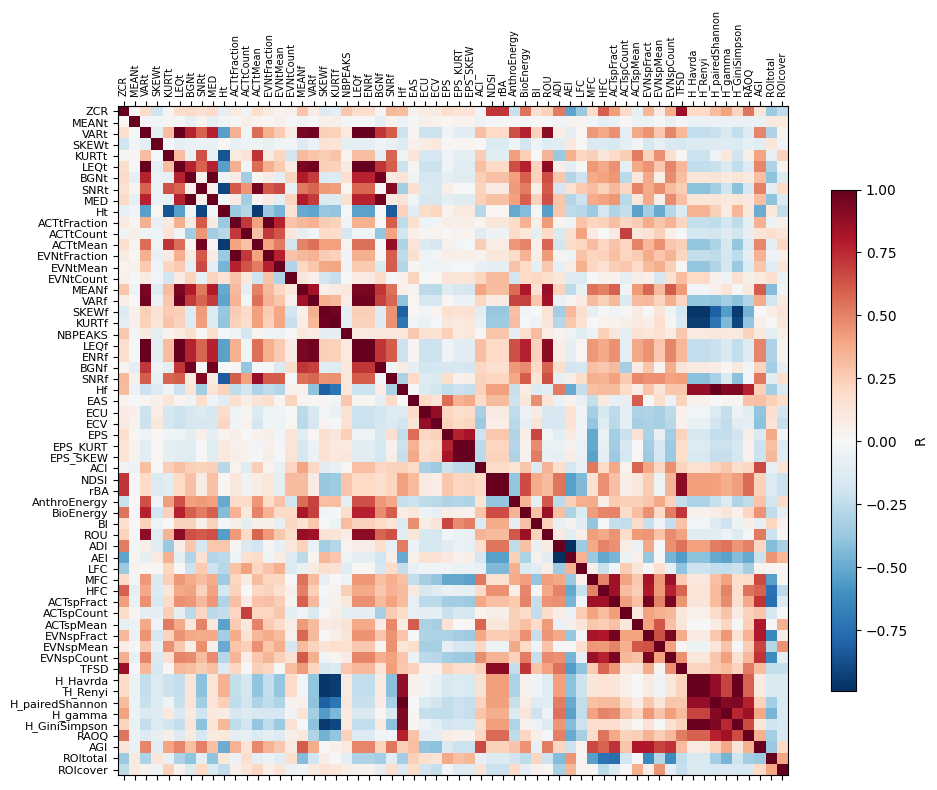

In [12]:
fig, ax = plot_correlation_map(df_indices, R_threshold=0)
fig.savefig(proj_path / "results" / (dataset_name + "_correlation_map.png"))

In [13]:
df_indices_corr = df_indices.copy()
df_indices_corr.set_index("Date", inplace=True)
df_indices_corr

file  \
Date                                                                     
2023-04-01 16:58:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-01 17:58:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-02 05:05:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-02 06:05:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-02 16:57:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
...                                                                ...   
2023-06-23 17:28:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-23 18:28:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-24 05:02:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-24 06:02:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-24 07:02:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   

                             ZCR         MEANt      VARt     SKEWt  \
Date                                                                 
2023-04-01 16:58:00  6077.152222  1.516458e-17  0.000036  0.557540   
2023-04-01 17:58:02  4201.031684 -4.426801e-19  0.000073 -0.080533   
2023-04-02 05:05:00  7243.363056 -4.403073e-18  0.000035 -0.085489   
2023-04-02 06:05:02  7048.376598 -6.105098e-18  0.000195  3.840068   
2023-04-02 16:57:00  6082.141389 -9.239510e-19  0.000019  0.052590   
...                          ...           ...       ...       ...   
2023-06-23 17:28:02  4081.982768  7.151975e-17  0.000103  0.046312   
2023-06-23 18:28:02  3697.847052 -1.721990e-17  0.000205  0.010016   
2023-06-24 05:02:00  1966.267222 -5.933440e-18  0.000046  0.069677   
2023-06-24 06:02:02  2296.571984  1.298437e-17  0.000297 -1.016845   
2023-06-24 07:02:02  2408.369299  3.401061e-19  0.000182  0.048826   

                          KURTt       LEQt       BGNt      SNRt       MED  \
Date                                                                        
2023-04-01 16:58:00  114.239488  72.553697 -38.765477  3.636473  0.011527   
2023-04-01 17:58:02  105.431184  75.633304 -38.554948  4.939499  0.011810   
2023-04-02 05:05:00   37.486077  72.500945 -38.218555  3.357568  0.012276   
2023-04-02 06:05:02  741.794819  79.925328 -37.065153  8.184796  0.014020   
2023-04-02 16:57:00   10.913952  69.754567 -39.930228  2.022253  0.010081   
...                         ...        ...        ...       ...       ...   
2023-06-23 17:28:02  120.356562  77.162507 -34.762037  3.828299  0.018277   
2023-06-23 18:28:02   73.092306  80.133162 -31.391701  3.570467  0.026941   
2023-06-24 05:02:00    9.487745  73.671253 -37.153277  2.835588  0.013878   
2023-06-24 06:02:02  128.966058  81.743884 -32.596123  6.203866  0.023453   
2023-06-24 07:02:02   13.368433  79.625973 -29.761386  1.779087  0.032504   

                     ...      TFSD  H_Havrda   H_Renyi  H_pairedShannon  \
Date                 ...                                                  
2023-04-01 16:58:00  ...  0.558352  0.332716  3.145451         5.529306   
2023-04-01 17:58:02  ...  0.464040  0.333275  4.325385         6.017202   
2023-04-02 05:05:00  ...  0.737076  0.333276  4.331972         6.518704   
2023-04-02 06:05:02  ...  0.655549  0.325071  1.848713         4.585921   
2023-04-02 16:57:00  ...  0.514656  0.332579  3.045795         5.691992   
...                  ...       ...       ...       ...              ...   
2023-06-23 17:28:02  ...  0.466456  0.332842  3.259871         5.922971   
2023-06-23 18:28:02  ...  0.579934  0.333227  4.025011         5.971553   
2023-06-24 05:02:00  ...  0.156972  0.333061  3.554955         5.057683   
2023-06-24 06:02:02  ...  0.307738  0.332489  2.989173         5.099512   
2023-06-24 07:02:02  ...  0.322369  0.333251  4.154282         5.850343   

                          H_gamma  H_GiniSimpson      RAOQ       AGI  \
Date                                                                   
2023-04-01 16:58:00  27511.228677       0.970896  0.564423  1.738315  

In [14]:
df_indices_per_bin_corr = df_indices_per_bin.copy()
df_indices_per_bin_corr.set_index("Date", inplace=True)
df_indices_per_bin_corr

file  \
Date                                                                     
2023-04-01 16:58:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-01 17:58:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-02 05:05:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-02 06:05:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-04-02 16:57:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
...                                                                ...   
2023-06-23 17:28:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-23 18:28:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-24 05:02:00  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-24 06:02:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   
2023-06-24 07:02:02  /home/andrei/WUR/Projects/Ecoacoustics/ecoacou...   

                                                           frequencies  \
Date                                                                     
2023-04-01 16:58:00  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-04-01 17:58:02  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-04-02 05:05:00  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-04-02 06:05:02  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-04-02 16:57:00  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
...                                                                ...   
2023-06-23 17:28:02  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-06-23 18:28:02  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-06-24 05:02:00  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-06-24 06:02:02  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   
2023-06-24 07:02:02  [0.0, 23.4375, 46.875, 70.3125, 93.75, 117.187...   

                                                                   LTS  \
Date                                                                     
2023-04-01 16:58:00  [9.35071867239232e-08, 1.1878773772399017e-07,...   
2023-04-01 17:58:02  [1.04219866214365e-07, 1.866238908290218e-07, ...   
2023-04-02 05:05:00  [3.383794486485125e-08, 3.105841069091241e-08,...   
2023-04-02 06:05:02  [5.211938926540677e-07, 2.9031533844383393e-07...   
2023-04-02 16:57:00  [7.272221297988993e-08, 1.295033835609493e-07,...   
...                                                                ...   
2023-06-23 17:28:02  [1.6771667522324046e-07, 1.576153127538147e-07...   
2023-06-23 18:28:02  [1.3328627693307886e-07, 1.843876957810258e-07...   
2023-06-24 05:02:00  [5.507274247888755e-08, 7.025254202388705e-08,...   
2023-06-24 06:02:02  [2.7133142071353034e-07, 3.0144548392849164e-0...   
2023-06-24 07:02:02  [1.8900494143558155e-07, 1.6269640548174615e-0...   

                                                         MEANt_per_bin  \
Date                                                                     
2023-04-01 16:58:00  [0.00019451491289888568, 0.0002690924699988512...   
2023-04-01 17:58:02  [0.0002060100418623376, 0.0003157635885306465,...   
2023-04-02 05:05:00  [0.00011738220931929383, 0.0001478304873146829...   
2023-04-02 06:05:02  [0.00020517071623254833, 0.0002936179611814345...   
2023-04-02 16:57:00  [0.00018678762748613247, 0.000280374568956976,...   
...                                                                ...   
2023-06-23 17:28:02  [0.00023303793875717091, 0.0003205785889058353...   
2023-06-23 18:28:02  [0.00027230663668943814, 0.0003559713120762640...   
2023-06-24 05:02:00  [0.00017401464868099995, 0.0002260864938636695...   
2023-06-24 06:02:02  [0.00027637531622736887, 0.000330195601307078,...   
2023-06-24 07:02:02  [0.00032201575741650136, 0.0003454754467237444...   

                                                          VARt_per_bin  \
Date                                                                     
2023-04-01 16:58:00  [5.567113538386384e-08, 4.6376980313910773e-0

# Visualisation

In case you cannot (don't want to) run all the processing prior to this step, precomputed indices can be simply loaded from disk.
To use the visualisations below please read the appropriate `.csv` files from `output` dir. 

Naming conventions: `<DatasetName>_indices.csv` and `<DatasetName>_indices_per_bin.csv`.

Then correct them -- set a "Date" column as index -- like so:
```python
df_indices_corr = pd.read_csv("path/to/csv")
df_indices_corr.set_index("Date", inplace=True)
```

Do the same for `indices_per_bin`. Having those 2 data frames

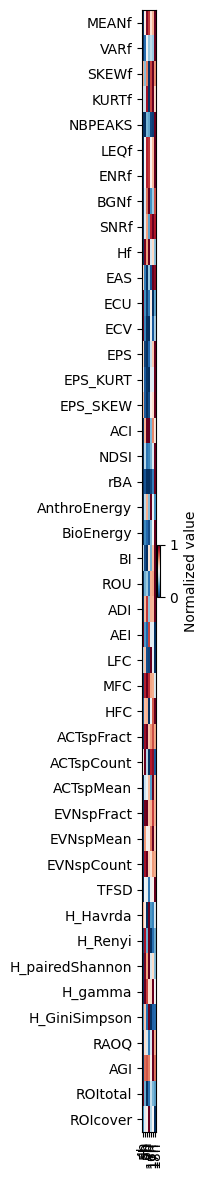

In [15]:
fig, ax = plot_features_map(df_indices_corr[SPECTRAL_FEATURES], mode='24h');
fig.savefig(proj_path / "results" / (dataset_name + "_features_map_spectral_24h.png"))

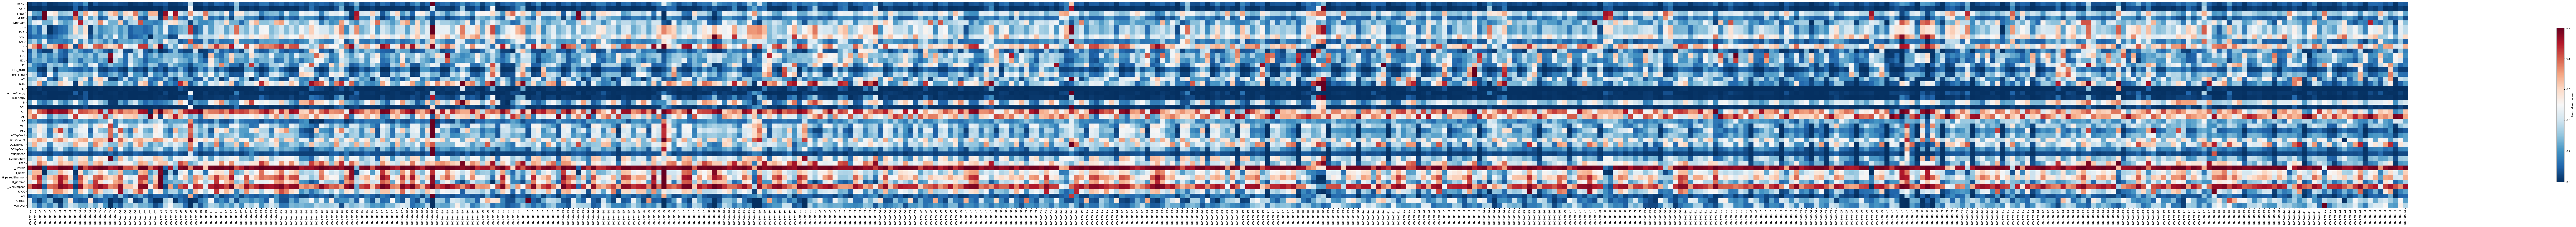

In [16]:
fig, ax = plot_features_map(df_indices_corr[SPECTRAL_FEATURES], mode='1H');
fig.savefig(proj_path / "results" / (dataset_name + "_features_map_spectral_1h.png"))

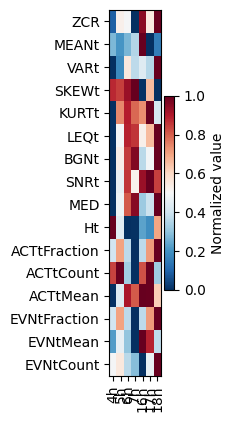

In [17]:
fig, ax = plot_features_map(df_indices_corr[TEMPORAL_FEATURES], mode='24h');
fig.savefig(proj_path / "results" / (dataset_name + "_features_map_temporal_24h.png"))

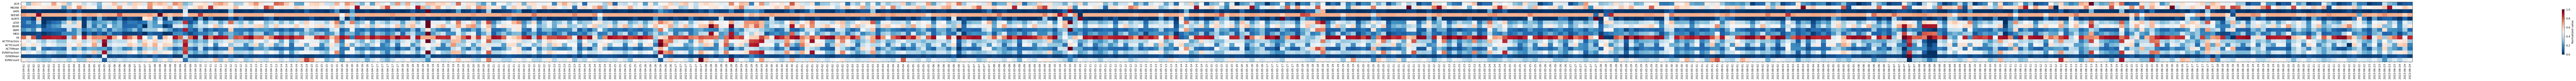

In [18]:
fig, ax = plot_features_map(df_indices_corr[TEMPORAL_FEATURES], mode='1H');
fig.savefig(proj_path / "results" / (dataset_name + "_features_map_temporal_1h.png"))

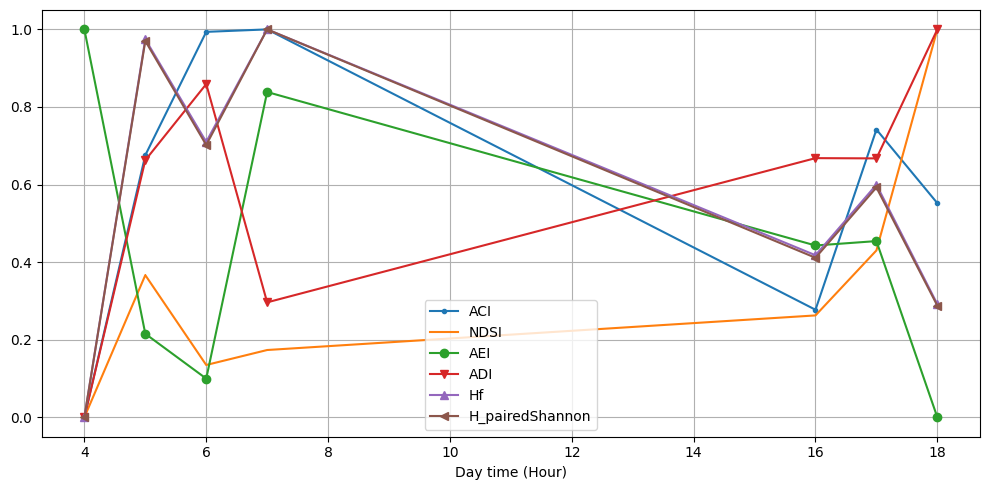

In [19]:
# A more classical way to analyse variations of indices consists in plotting
# graphs. We choose to normalize rescale their value between 0 to 1 in order to
# compare their trend during a 24h cycle
indices = ["ACI", "NDSI", "AEI", "ADI", "Hf", "H_pairedShannon"]
fig, ax = plot_features(df_indices_corr[indices], norm=True, mode='24h', figsize=(10, 5));
fig.savefig(proj_path / "results" / (dataset_name + "_selected_indices_24h.png"))

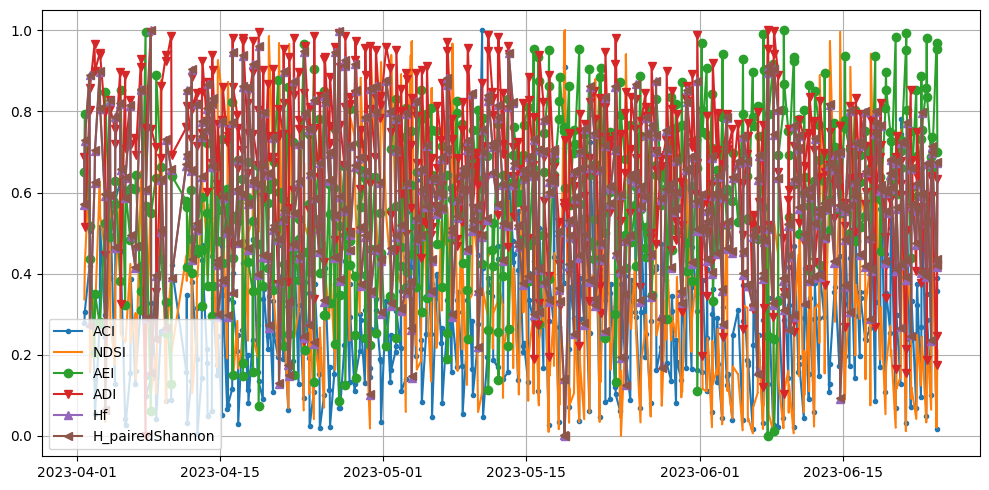

In [20]:
fig, ax = plot_features(df_indices_corr[indices], norm=True, mode='1H', figsize=(10, 5));
fig.savefig(proj_path / "results" / (dataset_name + "_selected_indices_1h.png"))

In [21]:
filename_prefix = str(proj_path / "results" / dataset_name)
fcs, triplet = false_Color_Spectro(
    df_indices_per_bin_corr,
    indices=["KURTt_per_bin", "EVNspCount_per_bin", "MEANt_per_bin"], #["ACI_per_bin", "KURTt_per_bin", "EVNspCount_per_bin"],
    reverseLUT=False,
    unit="hours",
    permut=False,
    display=True,
    figsize=(10, 7),
    savefig=filename_prefix
);